#### Ex1: Dùng Numpy implement thuật toán dbscan, test thử với dữ liệu.

In [1]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

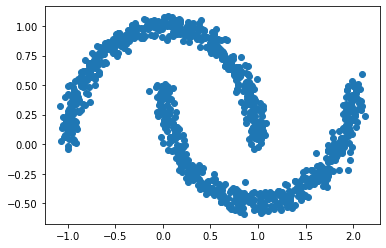

In [3]:
X, y = make_moons(n_samples=1010, noise=0.05)
plt.scatter(X[:,0], X[:,1])

In [5]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)
        
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters

Text(0, 0.5, 'Y')

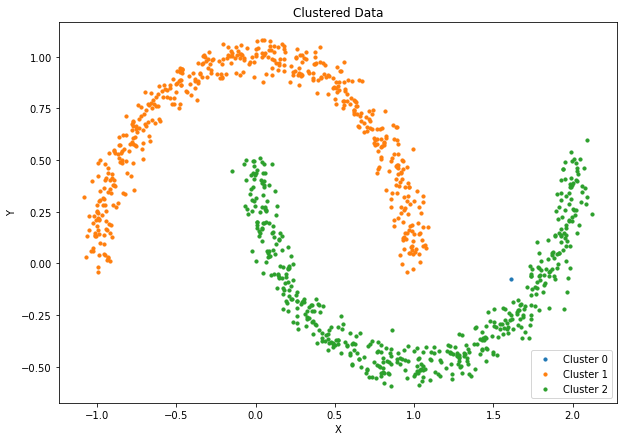

In [7]:
eps = 0.1
minPts = 3
data = pd.DataFrame(X, columns = ["X", "Y"] )
clustered = cluster_with_stack(eps, minPts, data)

idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')

#### Ex2: Ý nghĩa tham số radius, min sample trong thuật toán dbscan? Nếu chỉ số lớn, nhỏ ảnh hưởng thế nào tới thuật toán?

+ Radius r (eps) là bán kính từ 1 điểm (khoảng cách chỉ định các vùng lân cận) trong đó hai điểm được coi là hàng xóm nếu khoảng cách giữa chúng nhỏ hơn hoặc bằng eps. Nếu r lớn hơn, thì bán kinh cũng sẽ lớn hơn sẽ kéo nhiều điểm về cùng một nhóm và có nhiều nhiễu trong nhóm đó hơn dẫn đến vô nghĩa trong bài toán phân cụm. Nếu radius thấp đi và có thể bị thiếu mất dữ liệu dẫn đến nhiễu và không phân cụm được.
+ MinPts là số điểm dữ liệu tối thiểu để xác định một cụm. Số lượng minPts không bao gồm điểm ở tâm. Nếu minPts thấp đi, thì sẽ có nhiều core point hơn nên sẽ nhiễu hơn. Nếu minPts tăng lên, sẽ khó hơn để trở thành 1 core point, nhiều điểm sẽ bị coi là nhiễu, số lượng nhóm phân loại được sẽ ít đi dẫn đến không chính xác

#### Ex3: Biến đổi lại và so sánh ba thuật toán: kmean, GMM, dbscan. Khi nào nên sử dụng thuật toán nào? cho ví dụ?

#### K-means

##### Ưu điểm:
+ Đơn giản, dễ hiểu, tương đối hiệu quả.
+ Các đối tượng tự động gán vào nhóm.
+ Thường được tối ưu cục bộ.

##### Nhược điểm
+ Các thuộc tính không phải số.
+ Cần xác định số nhóm (KK) trước.
+ Phụ thuộc vào việc chọn các nhóm đầu tiên.
+ Gặp vấn đề khi các nhóm có kích thước, mật độ khác nhau hoặc hình dáng không phải hình cầu.
+ Nhạy cảm với dữ liệu nhiễu hay outliers : Khi xuất hiện outliers thì thường khiến cho tâm cụm bị chệch và do đó dự báo cụm không còn chuẩn xác

=> Trường hợp sử dụng: kích thước cụm đồng đều, hình học phẳng, không quá nhiều cụm.

#### GMM

##### Ưu điểm
+ Xử lý nhiều hình dạng hơn, chủ yếu là các cụm tạo thành hình elip (K-Means chỉ thực sự tốt ở các cụm có dạng gần giống hình cầu)
+ Soft assignment: trong k-means 1 điểm chỉ thuộc 1 cluster do k-means là hard assigment. Tuy nhiên, ở trong GMM, 1 điểm có thể thuộc vào nhiều cluster với mức độ khác nhau. Điều này hữu ích trong một số task như một bài báo có thể thuộc nhiều chủ đề,..

##### Nhược điểm
+ không xác định chính xác được một số cụm có hình dạng khác

=> Trường hợp sử dụng: ước tính mật độ và hình học phẳng.

#### DBScan

##### Ưu điểm
+ Tự động loại bỏ được các điểm dữ liệu nhiễu
+ Có tốc độ tính toán nhanh.
+ Không yêu cầu xác định trước số lượng cụm.
+ Hoạt động tốt với các cụm hình dạng tùy ý.
+ DBSCAN mạnh mẽ đối với các ngoại lệ và có thể phát hiện các ngoại lệ.

##### Nhược điểm
+ Không hiệu quả đối với những dữ liệu có phân phối đều khắp nơi.
+ Nếu các cụm rất khác nhau về mật độ trong cụm, thì DBSCAN không phù hợp để xác định các cụm.
+ Nhạy cảm với các thông số eps và minPts.

=> Trường hợp sử dụng: kích thước cụm không đồng đều và hình học không phẳng